# RNA Velocity

Here we are looking at the RNA velocity of combined samples from the 'aged' group

In [2]:
import loompy
import scvelo as scv
#scv.logging.print_version(), not running this line seems to avoid the dead kernel at the pp.neigbors step

In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization


### Load the Data

In [8]:
ldata = scv.read('Loom_files/aged_merged.loom', cache=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
adata = scv.read('write/Mapped_ingest_aged.h5ad', cache=True)

In [10]:
adata = scv.utils.merge(adata, ldata)
adata

AnnData object with n_obs × n_vars = 9360 × 97
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'age', 'muscle', 'sample', 'batch', 'leiden', 'cell type', 'sample_batch', 'TotalUMIs', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'mt', 'highly_variable', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'mean-0', 'std-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean-1', 'std-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'mean-2', 'std-2', 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullNa

### Preprocess the Data

In [12]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:14) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Estimate RNA velocity

In [13]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [14]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Project the velocities

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_.pdf


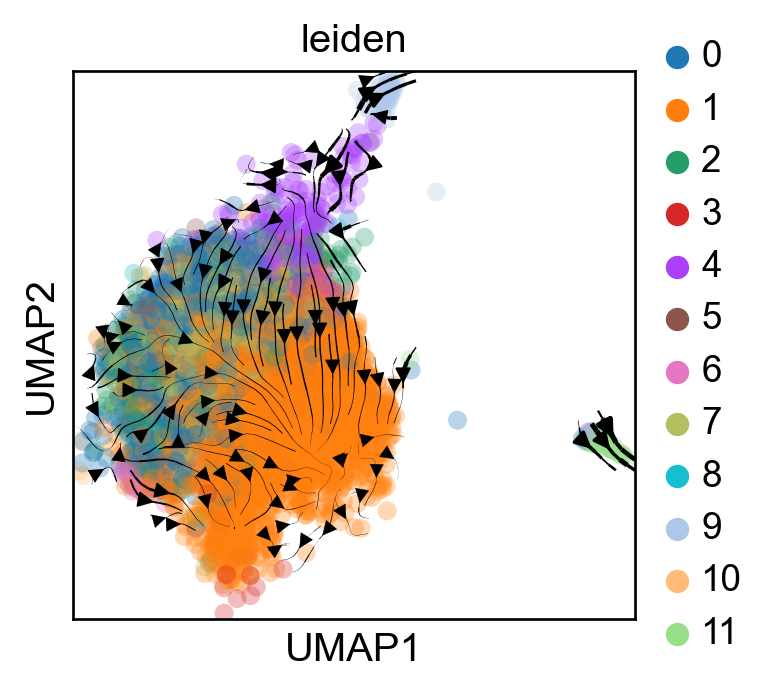

In [15]:
scv.settings.set_figure_params(dpi=120, frameon= False, figsize=(3, 3))
scv.pl.velocity_embedding_stream(adata, basis='umap', color= ['leiden'], legend_loc= 'right margin', frameon=True, save='.pdf')

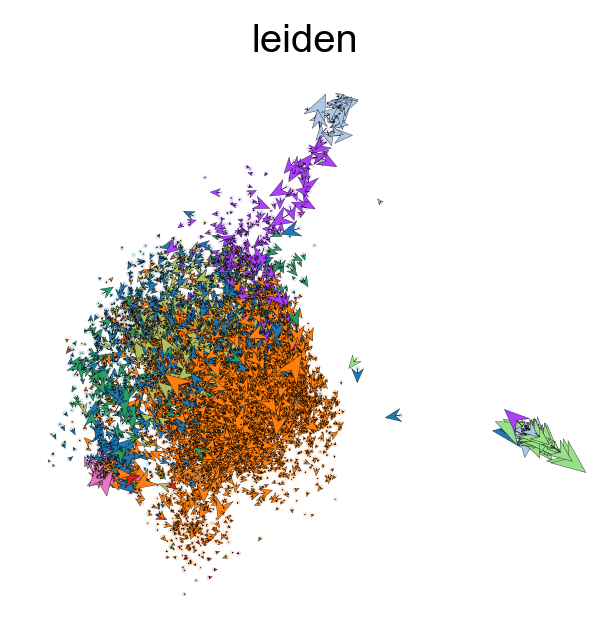

In [18]:
scv.pl.velocity_embedding(adata, arrow_length=10, arrow_size=10, dpi=120, color='leiden')


### PAGA velocity graph
[PAGA](https://doi.org/10.1186/s13059-019-1663-x) graph abstraction has benchmarked as top-performing method for trajectory inference. It provides a graph-like map of the data topology with weighted edges corresponding to the connectivity between two clusters. Here, PAGA is extended by velocity-inferred directionality.

In [25]:
# PAGA requires to install igraph, if not done yet.
!pip install python-igraph --upgrade --quiet

In [26]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='leiden')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0.56,0,0,0,0,0,0.48,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0.29,0,0,0,0,0,0,0,0,0,0
3,0,0.09,0,0,0,0,0,0,0,0,0,0
4,0,0.34,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0.043,0,0,0,0
6,0,0,0,0.021,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0.019,0,0,0,0,0,0,0.19


This reads from left/row to right/column, thus e.g. assigning a confident transition from Ductal to Ngn3 low EP. 

This table can be summarized by a directed graph superimposed onto the UMAP embedding.

saving figure to file ./figures/scvelo_paga_old.pdf


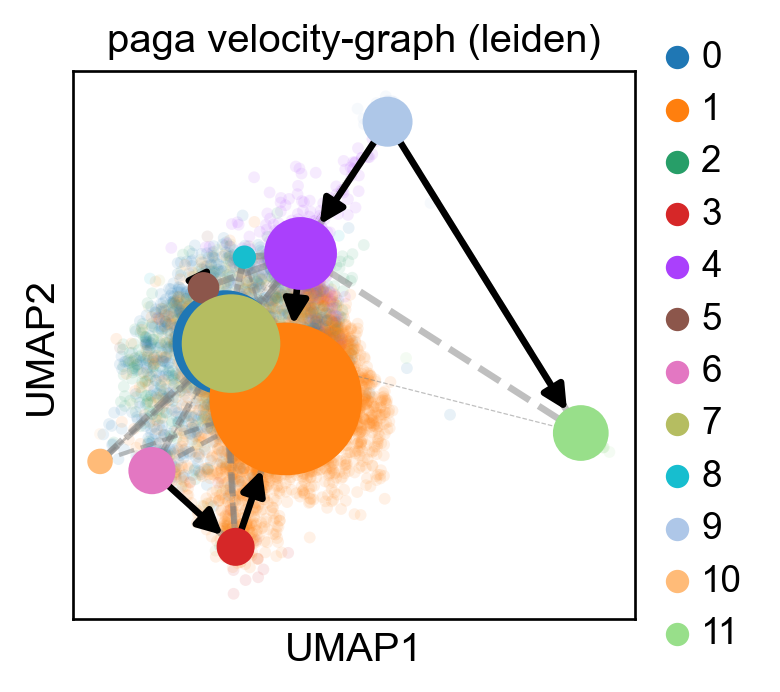

In [43]:
scv.pl.paga(adata, basis='umap', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5, frameon=True, save = 'paga_old')